## testing with south sudan UCDP data 

timeline for [south sudanese conflict](https://concernusa.org/news/timeline-south-sudan-history/)

methods should look at 2013-2015 and post peace process

In [50]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%run ../../eda/cleaning_ucdp.ipynb


In [51]:
# data = pd.read_csv('../../data/ucdp/sri_lanka.csv')
# data.sort_values(by='date_start', inplace=True)

# hm = pd.to_datetime(data['date_start']).dt.tz_localize('Africa/Juba').dt.tz_convert('UTC')

In [67]:
country = "sri_lanka"
full_path = '../../data/ucdp/sri_lanka.csv'
ucleaner = UCDPCleaner(country, full_path=full_path)
data_duration = ucleaner.duration()
ucleaner.set_data(data_duration)

Loading data from ../../data/ucdp/sri_lanka.csv


In [68]:
data = ucleaner.data
data.columns

subset = data[["id", "year", "active_year", "conflict_new_id", "duration", "best", "date_start", "date_end", "priogrid_gid", "country", "region"]]

ucleaner.set_data(subset)
m_resample = ucleaner.resample('M', war_var=False)
# Convert 'avg_duration' from timedelta to total seconds for model compatibility
m_resample['avg_duration'] = m_resample['avg_duration'].fillna(pd.Timedelta(seconds=0))
m_resample['avg_duration'] = m_resample['avg_duration'].dt.total_seconds().astype(int)


In [69]:
def create_sliding_window(data, window_size):
    for i in range(1, window_size + 1):
        data[f'best_lag_{i}'] = data['best'].shift(i)
    return data.dropna()

window_size = 4  # 4-6 seems to be ideal
X = create_sliding_window(m_resample, window_size)
X.head()

,best,unique_conflicts,avg_duration,events_count,best_lag_1,best_lag_2,best_lag_3,best_lag_4
date_start,,,,,,,,
1989-05-31,72,5,271542,7,108.0,18.0,110.0,36.0
1989-06-30,27,2,0,12,72.0,108.0,18.0,110.0
1989-07-31,47,3,7854,11,27.0,72.0,108.0,18.0
1989-08-31,120,4,100800,36,47.0,27.0,72.0,108.0
1989-09-30,38,3,31831,19,120.0,47.0,27.0,72.0


In [70]:
y = X['best']
y.head()

date_start
1989-05-31     72
1989-06-30     27
1989-07-31     47
1989-08-31    120
1989-09-30     38
Freq: M, Name: best, dtype: int64

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1423.4939472222222


# everything here down is from before

In [17]:
def create_window_with_time(data, timestamps, window_size):
    X, y, y_timestamps = [], [], []
    for i in range(len(data) - window_size):
        X.append(data.iloc[i:(i + window_size)].values)
        y.append(data.iloc[i + window_size])
        y_timestamps.append(timestamps.iloc[i + window_size])
    return np.array(X), np.array(y), np.array(y_timestamps)

window_size = 4 
X, y, y_timestamps = create_window_with_time(data['best'], hm, window_size)

In [18]:
X_train, X_test, y_train, y_test, y_timestamps_train, y_timestamps_test = train_test_split(X, y, y_timestamps, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1018.0055073330528


In [22]:
# Convert y_timestamps_test to a numpy array for indexing purposes
y_timestamps_test_np = np.array(y_timestamps_test)

# Get the sorted indices of y_timestamps_test
sorted_indices = np.argsort(y_timestamps_test_np)

# Use the sorted indices to sort X_test, y_test, and y_timestamps_test
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test[sorted_indices]
predictions_sorted = predictions[sorted_indices]
y_timestamps_test_sorted = y_timestamps_test_np[sorted_indices]

In [23]:
# Example conversion to a date string if y_timestamps_test is a pandas datetime series
y_timestamps_test_str = [timestamp.strftime('%Y-%m-%d') for timestamp in y_timestamps_test_sorted]


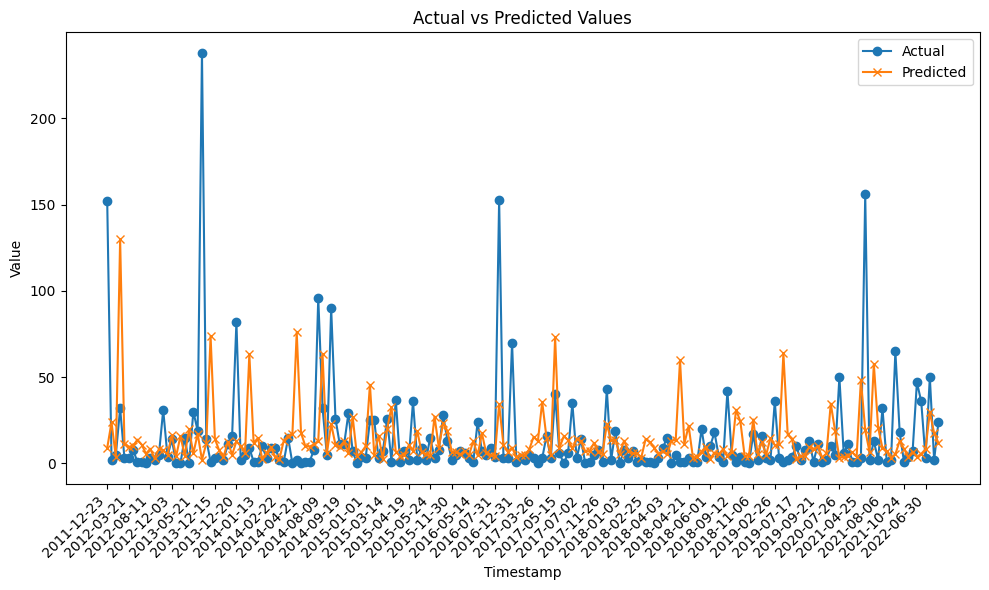

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure(figsize=(10, 6))

# Assuming y_test and predictions are of the same length
indices = range(len(y_test))

plt.plot(indices, y_test_sorted, label='Actual', marker='o')
plt.plot(indices, predictions_sorted, label='Predicted', marker='x')

plt.title('Actual vs Predicted Values')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()

# Set x-ticks to be the indices and label them with the corresponding timestamps
# Here, we use every nth label to avoid cluttering, adjust n as per your data size
n = 5  # Adjust n based on your dataset size to avoid clutter
plt.xticks(indices[::n], y_timestamps_test_str[::n], rotation=45, ha="right")

plt.tight_layout()
plt.show()

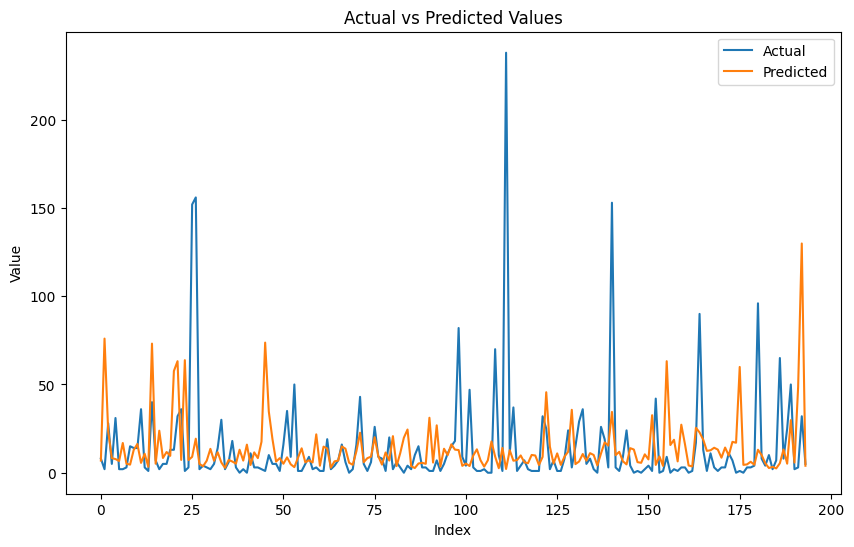

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()
